## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [2]:
ObsData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
#ObsData.columns = ObsData.columns.droplevel([3,4,5,6,7,8,10])
#ObsData = ObsData.reorder_levels(['Depth','Irrigation','Nitrogen','Block'],axis=1)
ObsData.sort_index(axis=0,inplace=True)
ObsData.sort_index(axis=1,inplace=True)
#Set up factorLevel descriptors
Depths = ObsData.columns.get_level_values(0).drop_duplicates().values
F1 = ObsData.columns.get_level_values(1).drop_duplicates().values
F2 = ObsData.columns.get_level_values(2).drop_duplicates().values
Blocks = ObsData.columns.get_level_values(3).drop_duplicates().values

## Export top layer data for evaporation analysis

In [3]:
ObsData.loc[:,['D1B','D1I']].to_pickle('.\DataFrames\TopVWC.pkl')

In [4]:
GPs = GH.SetGraphicsPatterns(ObsData.D1B.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = ObsData.index.min()
End = ObsData.index.max()

Irrigation
['Dry', 'Irrigated']
Cultivar
['Karaka', 'Moonlight', 'RussetB']
Treatments
MultiIndex(levels=[['Dry', 'Irrigated'], ['Karaka', 'Moonlight', 'RussetB']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
                    Lin     Col   Alp Mar     MFC
Dry       Karaka      -  orange  0.15   o  orange
          Moonlight   -   green  0.15   o   green
          RussetB     -  purple  0.15   o  purple
Irrigated Karaka     --  orange  0.45   ^   white
          Moonlight  --   green  0.45   ^   white
          RussetB    --  purple  0.45   ^   white


In [5]:
ObsData=ObsData.where(ObsData<0.7)

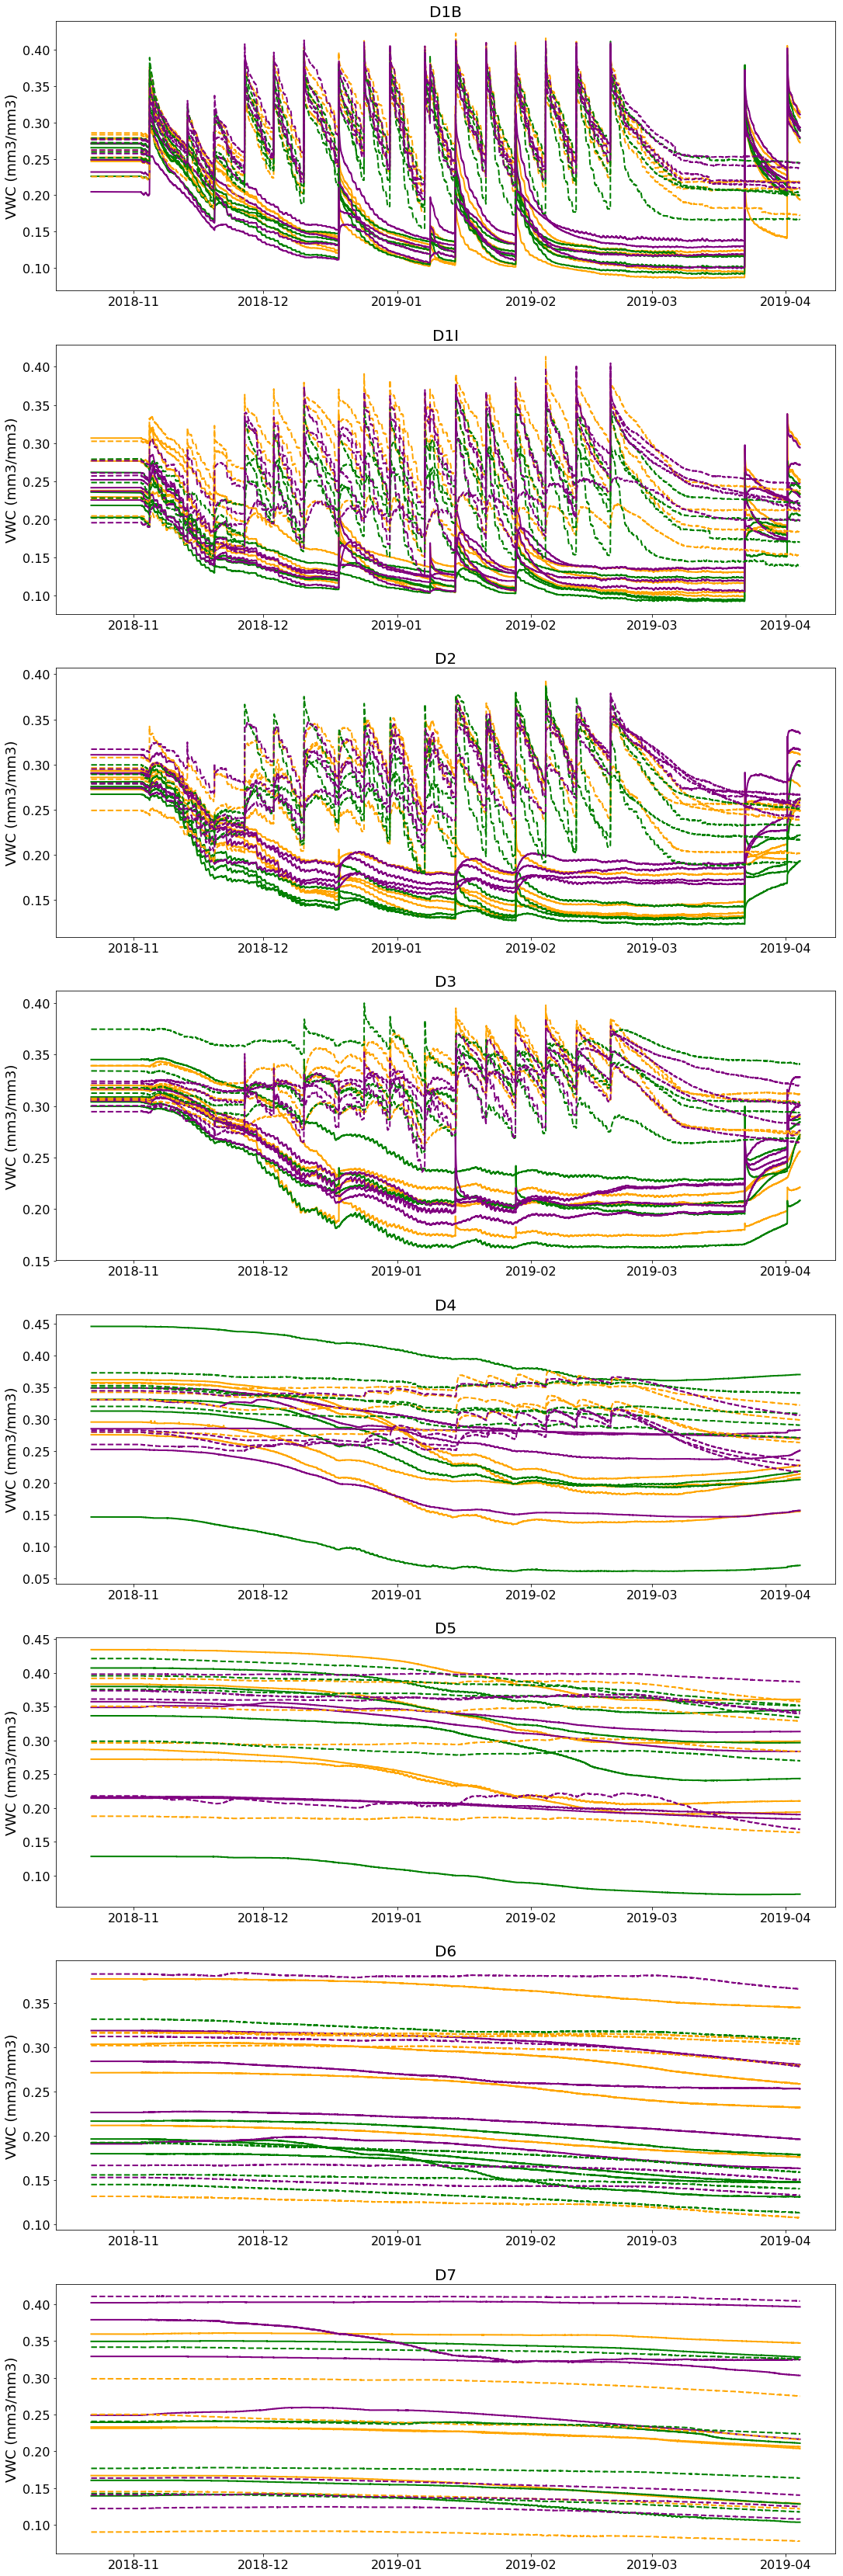

In [6]:
Graph = plt.figure(figsize=(18,60))
pos = 1
for D in Depths:
    ax = Graph.add_subplot(8,1,pos)
    GH.AddIndexedPlot(ObsData.loc[:,D],ax,GPs,2)
    plt.title(D,fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylabel('VWC (mm3/mm3)',fontsize=18)
    pos +=1

## Calculate soil water deficit

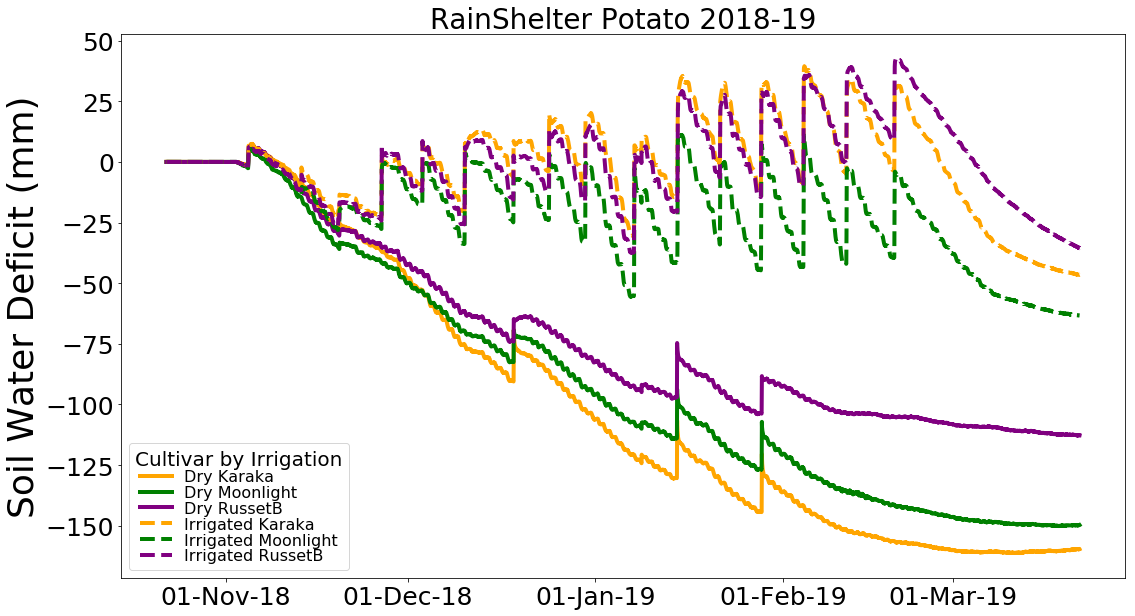

In [27]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  ObsData.groupby(level=['Depth','Irrigation', 'Cultivar'],axis=1).mean()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.loc[:,'D1I'] * 150/2 + \
               DataMeans.loc[:,'D1B'] * 150/2 + \
               DataMeans.loc[:,'D2'] * 150 + \
               DataMeans.loc[:,'D3'] * 300 + \
               DataMeans.loc[:,'D4'] * 300 + \
               DataMeans.loc[:,'D5'] * 300 + \
               DataMeans.loc[:,'D6'] * 300 + \
               DataMeans.loc[:,'D7'] * 300
                
FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.loc['2018-11-02']   # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater.loc[:'2019-03-21',:])    # This calculation only works because field capacity is a multi index series
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(SoilWaterDeficit,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Potato 2018-19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

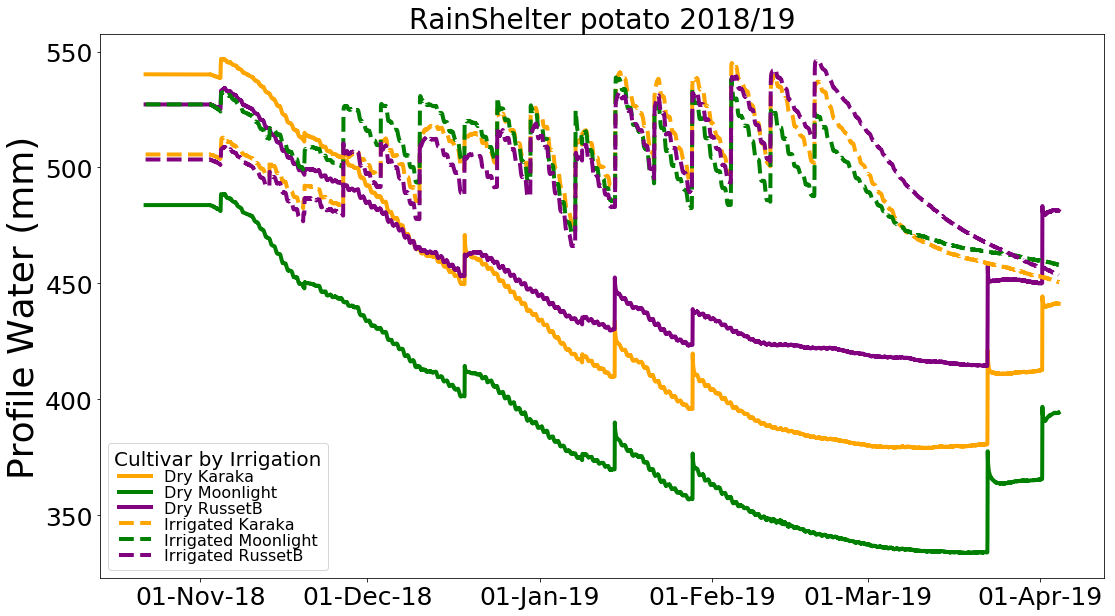

In [8]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(ProfileWater,ax,GPs,4)
plt.ylabel('Profile Water (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter potato 2018/19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

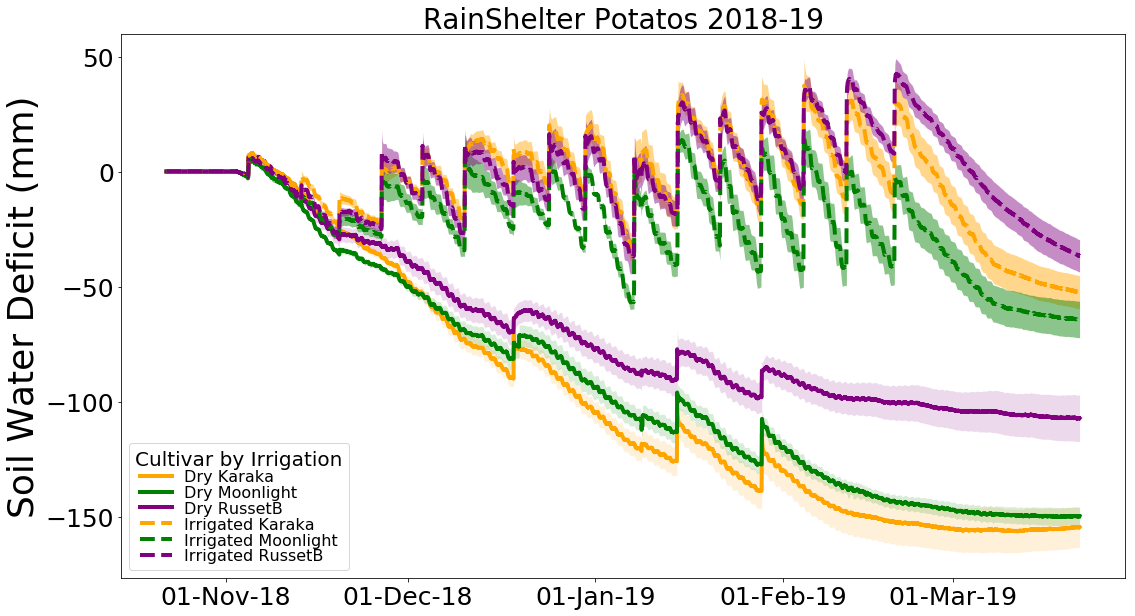

In [29]:
DataMeans2 = ObsData.groupby(level=['Depth', 'Irrigation', 'Cultivar','Block'],axis=1).mean()
DataMeans2 =  DataMeans2.dropna(axis=1, how = 'all')

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater2 = DataMeans2.loc[:,'D1I'] * 150/2 + \
               DataMeans2.loc[:,'D1B'] *150/2 + \
               DataMeans2.loc[:,'D2'] * 150 + \
               DataMeans2.loc[:,'D3'] * 300 + \
               DataMeans2.loc[:,'D4'] * 300 + \
               DataMeans2.loc[:,'D5'] * 300 + \
               DataMeans2.loc[:,'D6'] * 300 + \
               DataMeans2.loc[:,'D7'] * 300
                
FieldCapacity2 = ProfileWater2.resample('D').max()
FieldCapacity2 = FieldCapacity2.loc['2018-11-03'] 
SoilWaterDeficit2 = -(FieldCapacity2 - ProfileWater2.loc[:'2019-03-21',:])

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(SoilWaterDeficit2,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Potatos 2018-19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

In [34]:
FinalSWD = SoilWaterDeficit2.loc['2019-03-21',:].mean(axis=0)

In [35]:
FinalSWD.to_excel('FinalSWD.xls')

In [10]:
DeltaWater = ProfileWater2.diff()
DeltaWater.to_pickle('.\DataFrames\ProfileWaterDelta.pkl')
SWD = SoilWaterDeficit.resample('D').mean()
SWD.to_pickle('.\DataFrames\DailySWD.pkl')

In [11]:
DailyDeltaWater = DeltaWater.resample('d').sum().resample('d').sum()
DailyDeltaWater.where(DailyDeltaWater<2,np.nan,inplace=True)
DailyDeltaWater.to_pickle('.\DataFrames\DailyWU.pkl')